<a href="https://colab.research.google.com/github/nh0875/Desafios-Procesamiento-del-Habla-974/blob/main/Desafio_Clustering_Hilliard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Carga del Dataset**

El dataset que elgi tiene informacion sobre 4 grupos de enfermedades respiratorias, Chronic Obstructive Pulmonary Disease (COPD), asthma, infected, and Healthy Controls (HC),

Las columnas del mismo tienen informacion sobre la edad, el genero, el habito de fumar, y demas caracteristicas, como tambien el diagnostico final del paciente

Tiene una estructura de 9x400
https://archive.ics.uci.edu/dataset/523/exasens

Gender (Female=0 Male=1)

Somking (Non-smoker=1 Ex-smoker=2 Active-smoker=3)

In [13]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Cargar el dataset
file_path = '/content/Exasens.xlsx'
data = pd.read_excel(file_path)
print("Dataset original:")
print(data.head().to_string())

Dataset original:
      ID  Imaginary Part MIN  Imaginary Part MAX  Real Part MIN  Real Part MAX  Gender  Age  Smoking Diagnosis
0  301-4             -320.61         -300.563531        -495.26    -464.171991       1   77        2      COPD
1  302-3             -325.39         -314.750360        -473.73    -469.263140       0   72        2      COPD
2  303-3             -323.00         -317.436056        -476.12    -471.897667       1   73        3      COPD
3  304-4             -327.78         -317.399670        -473.73    -468.856388       1   76        2      COPD
4  305-4             -325.39         -316.155785        -478.52    -472.869783       0   65        2      COPD


# **Preprocesamiento**
 Identifico y estandarizo las columnas numéricas del dataset, dado que los algoritmos de clustering como K-Means son sensibles a las escalas de los datos. Además, procedo a dividir el dataset en conjuntos de entrenamiento y prueba (70%-30%) con el fin de validar los modelos. Aplico PCA para reducir la dimensionalidad a dos componentes principales, lo que facilita la visualización y mejora el rendimiento de los algoritmos.

 Grafico la distribucion de los datos con PCA y como esta distribuida la variable Diagnosis

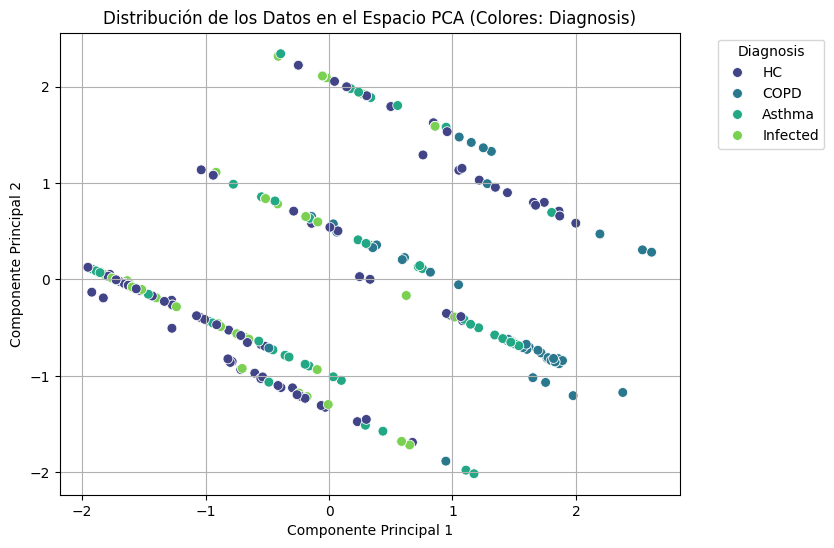

<ipython-input-15-522cc8780af1>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


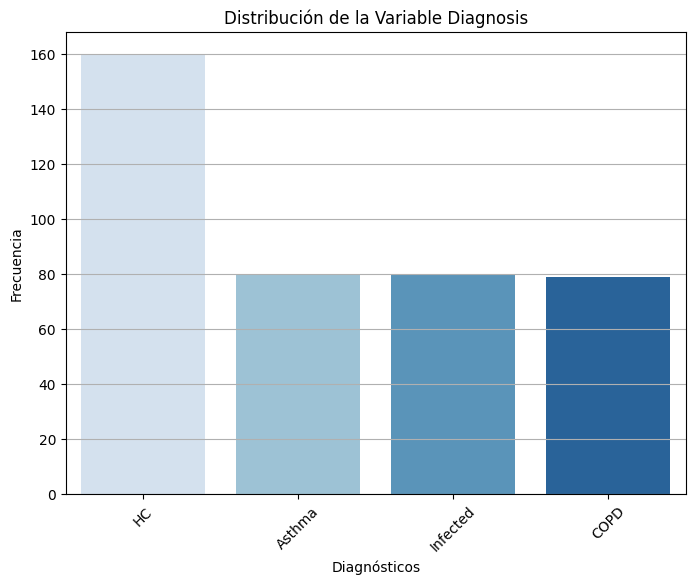

In [15]:
# 2. Preprocesamiento
## Identificar columnas numéricas para estandarización
numeric_cols = data.select_dtypes(include=[np.number]).columns

## Estandarizar datos (respetando los valores faltantes)
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Dividir en entrenamiento y prueba
X_train, X_test = train_test_split(data_scaled[numeric_cols], test_size=0.3, random_state=42)

## Aplicar PCA para reducir dimensiones a 2 componentes (respetando valores faltantes)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.fillna(0))  # Los valores faltantes se manejan temporalmente como 0
X_test_pca = pca.transform(X_test.fillna(0))  # Mismo tratamiento para datos de prueba

# Eliminar filas con valores faltantes en las columnas seleccionadas
X_train = X_train[~np.isnan(X_train).any(axis=1)]
X_test = X_test[~np.isnan(X_test).any(axis=1)]

# Visualización de la distribución original de los datos en el espacio cartesiano (PCA)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=data.loc[X_train.index, 'Diagnosis'],  # Usar el índice original para mapear Diagnosis
    palette="viridis",
    s=50
)
plt.title("Distribución de los Datos en el Espacio PCA (Colores: Diagnosis)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Diagnosis", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



plt.figure(figsize=(8, 6))
sns.countplot(
    data=data,
    x='Diagnosis',
    palette="Blues",
    order=data['Diagnosis'].value_counts().index
)
plt.title("Distribución de la Variable Diagnosis")
plt.xlabel("Diagnósticos")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# **Modelos**
K-Means: Agrupa los datos en 4 clusters predefinidos.
DBSCAN: Un algoritmo basado en densidad que no requiere definir un número de clusters, pero que marca los puntos ruidosos como -1.

Calculo las siguientes metricas para evaluar mis modelos:

Silhouette Score: Evalúa qué tan bien separados están los clusters (mejor cuanto más cercano a 1).

Davies-Bouldin Index: Mide la compacidad de los clusters y su separación (mejor cuanto más cercano a 0).
Para DBSCAN, se filtran los puntos ruidosos (-1).

Silhouette Score K-Means (train): 0.5039543475133352
Silhouette Score DBSCAN (train): 0.42258145949943876


<Figure size 1000x500 with 0 Axes>

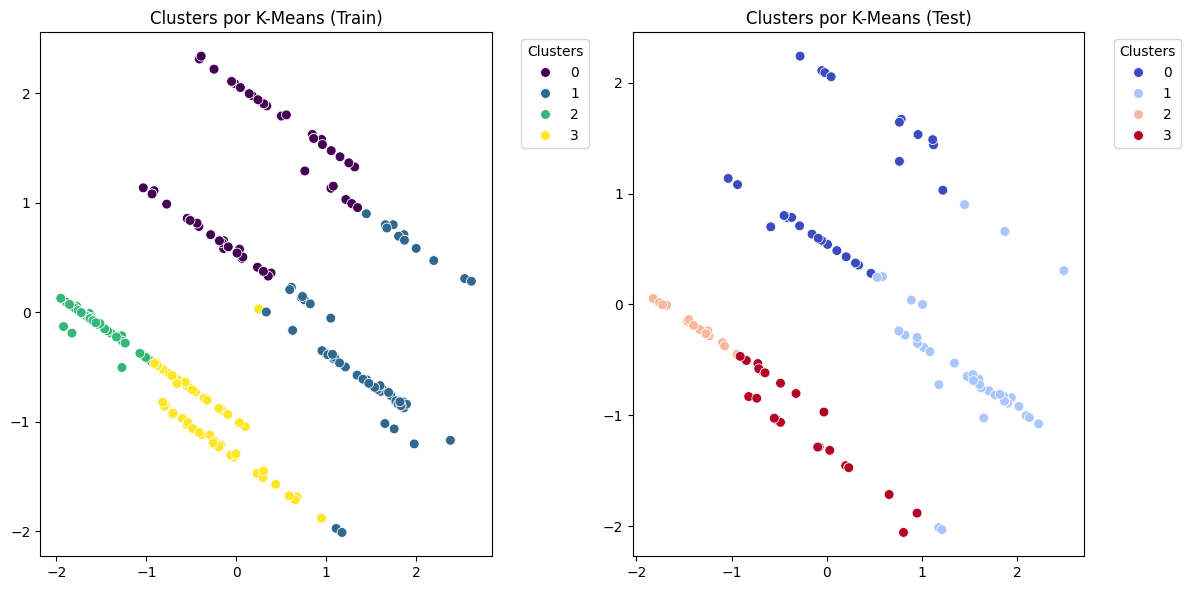

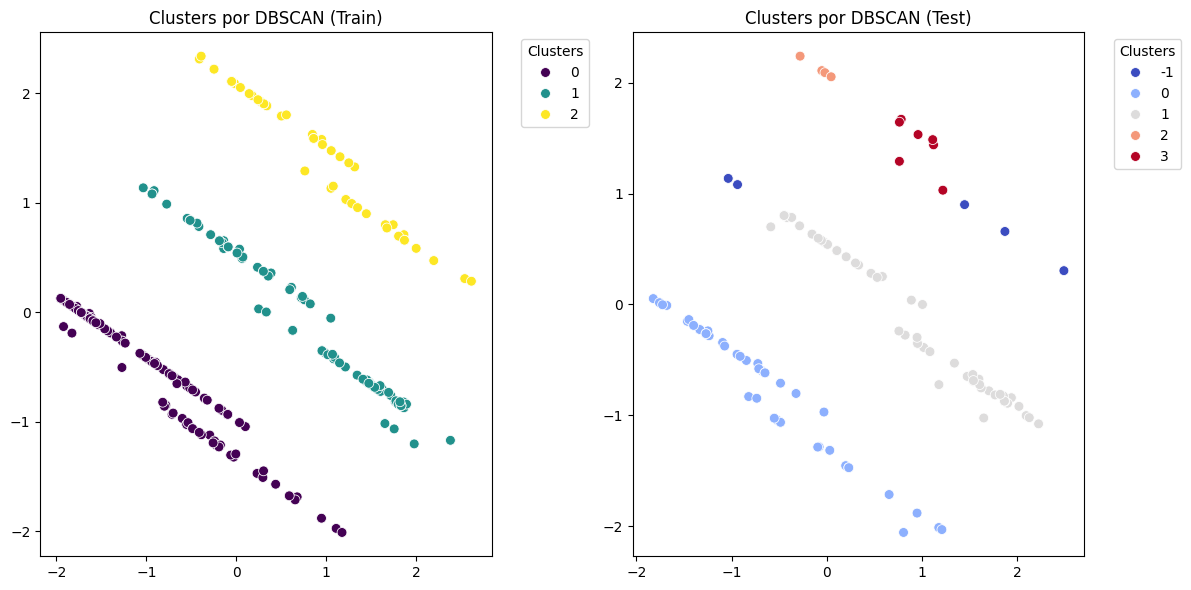

In [9]:
# 3. Modelos de clustering
## K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels_train = kmeans.fit_predict(X_train_pca)
kmeans_labels_test = kmeans.predict(X_test_pca)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels_train = dbscan.fit_predict(X_train_pca)
dbscan_labels_test = dbscan.fit_predict(X_test_pca)

# 4. Evaluación en entrenamiento
## Silhouette Score
silhouette_kmeans_train = silhouette_score(X_train_pca, kmeans_labels_train)

# Para DBSCAN, filtrar ruido (-1) en los datos y los labels
dbscan_mask = dbscan_labels_train != -1  # Mascara para filtrar ruido
silhouette_dbscan_train = silhouette_score(
    X_train_pca[dbscan_mask], dbscan_labels_train[dbscan_mask]
)

print(f"Silhouette Score K-Means (train): {silhouette_kmeans_train}")
print(f"Silhouette Score DBSCAN (train): {silhouette_dbscan_train}")

# 5. Visualización
plt.figure(figsize=(10, 5))
# Visualización de K-Means

plt.figure(figsize=(12, 6))

# Gráfico para K-Means (Train)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=kmeans_labels_train, palette="viridis", s=50
)
plt.title("Clusters por K-Means (Train)")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico para K-Means (Test)
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=kmeans_labels_test, palette="coolwarm", s=50
)
plt.title("Clusters por K-Means (Test)")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Visualización de DBSCAN

plt.figure(figsize=(12, 6))

# Gráfico para DBSCAN (Train)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=dbscan_labels_train, palette="viridis", s=50
)
plt.title("Clusters por DBSCAN (Train)")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico para DBSCAN (Test)
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=dbscan_labels_test, palette="coolwarm", s=50
)
plt.title("Clusters por DBSCAN (Test)")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# **Metricas de Evaluacion**


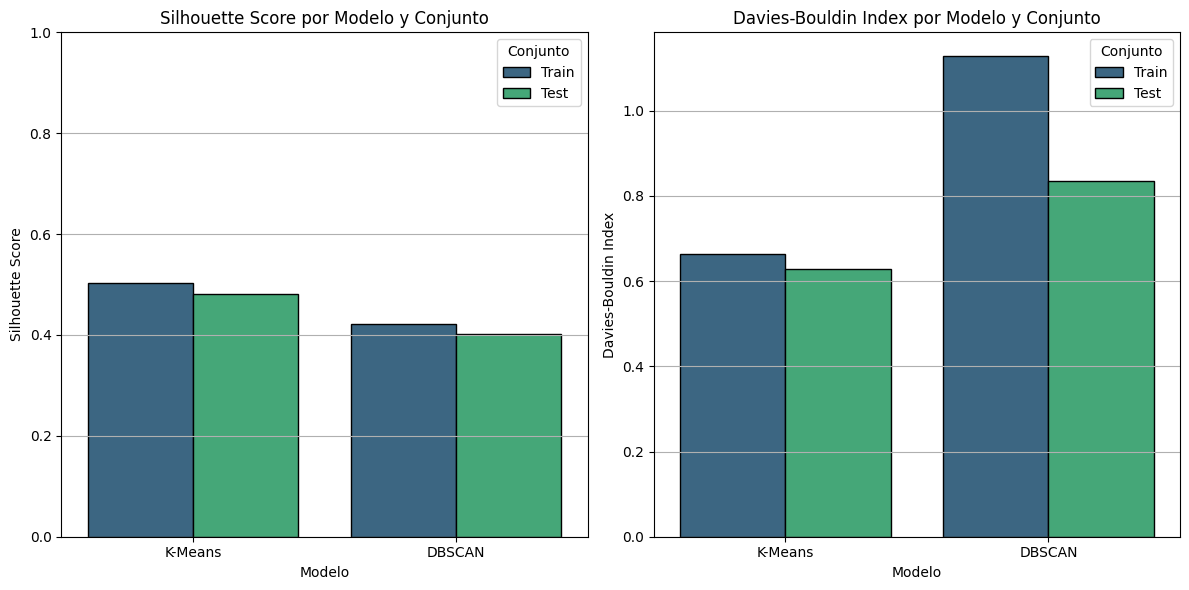

In [11]:
# Importar las métricas necesarias
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 1. Calcular Silhouette Score para K-Means
silhouette_kmeans_train = silhouette_score(X_train_pca, kmeans_labels_train)
silhouette_kmeans_test = silhouette_score(X_test_pca, kmeans_labels_test)

# 2. Calcular Silhouette Score para DBSCAN
# Filtrar ruido (-1) para evitar problemas en DBSCAN
dbscan_mask_train = dbscan_labels_train != -1
dbscan_mask_test = dbscan_labels_test != -1

if np.any(dbscan_mask_train):  # Verificar si hay puntos válidos
    silhouette_dbscan_train = silhouette_score(
        X_train_pca[dbscan_mask_train], dbscan_labels_train[dbscan_mask_train]
    )
else:
    silhouette_dbscan_train = None  # No se puede calcular si todo es ruido

if np.any(dbscan_mask_test):  # Verificar si hay puntos válidos
    silhouette_dbscan_test = silhouette_score(
        X_test_pca[dbscan_mask_test], dbscan_labels_test[dbscan_mask_test]
    )
else:
    silhouette_dbscan_test = None

# 3. Calcular Davies-Bouldin Index para K-Means
davies_bouldin_kmeans_train = davies_bouldin_score(X_train_pca, kmeans_labels_train)
davies_bouldin_kmeans_test = davies_bouldin_score(X_test_pca, kmeans_labels_test)

# 4. Calcular Davies-Bouldin Index para DBSCAN (sin ruido)
if np.any(dbscan_mask_train):  # Verificar si hay puntos válidos
    davies_bouldin_dbscan_train = davies_bouldin_score(
        X_train_pca[dbscan_mask_train], dbscan_labels_train[dbscan_mask_train]
    )
else:
    davies_bouldin_dbscan_train = None

if np.any(dbscan_mask_test):  # Verificar si hay puntos válidos
    davies_bouldin_dbscan_test = davies_bouldin_score(
        X_test_pca[dbscan_mask_test], dbscan_labels_test[dbscan_mask_test]
    )
else:
    davies_bouldin_dbscan_test = None
import pandas as pd

metrics_data = {
    "Modelo": ["K-Means", "K-Means", "DBSCAN", "DBSCAN"],
    "Conjunto": ["Train", "Test", "Train", "Test"],
    "Silhouette Score": [
        silhouette_kmeans_train,
        silhouette_kmeans_test,
        silhouette_dbscan_train,
        silhouette_dbscan_test,
    ],
    "Davies-Bouldin Index": [
        davies_bouldin_kmeans_train,
        davies_bouldin_kmeans_test,
        davies_bouldin_dbscan_train,
        davies_bouldin_dbscan_test,
    ],
}

metrics_df = pd.DataFrame(metrics_data)

# Crear un gráfico de barras agrupado
plt.figure(figsize=(12, 6))

# Gráfico para Silhouette Score
plt.subplot(1, 2, 1)
sns.barplot(
    data=metrics_df,
    x="Modelo",
    y="Silhouette Score",
    hue="Conjunto",
    palette="viridis",
    edgecolor="black",
)
plt.title("Silhouette Score por Modelo y Conjunto")
plt.ylim(0, 1)  # El índice de silueta está en el rango [0, 1]
plt.ylabel("Silhouette Score")
plt.grid(axis="y")
plt.legend(title="Conjunto")

# Gráfico para Davies-Bouldin Index
plt.subplot(1, 2, 2)
sns.barplot(
    data=metrics_df,
    x="Modelo",
    y="Davies-Bouldin Index",
    hue="Conjunto",
    palette="viridis",
    edgecolor="black",
)
plt.title("Davies-Bouldin Index por Modelo y Conjunto")
plt.ylabel("Davies-Bouldin Index")
plt.grid(axis="y")
plt.legend(title="Conjunto")

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

# **Analisis de las Metricas**
Para KMeans, los valores del Silhouette Score son similares para los conjuntos de entrenamiento y prueba, lo cual indica que este modelo tiene un rendimiento consistente en ambos conjuntos.
Para DBSCAN, los valores son más bajos que los de KMeans, lo que podría indicar que los clusters definidos por DBSCAN son menos compactos o menos bien separados.

KMeans muestra valores más bajos que DBSCAN para ambas divisiones (entrenamiento y prueba), lo que sugiere que este modelo produce clusters más definidos y separados.
DBSCAN presenta índices más altos, lo que puede deberse a una configuración subóptima de sus parámetros (como el eps o el número mínimo de puntos).

KMeans parece ser un modelo más robusto y consistente para estos datos en comparación con DBSCAN

# **Analisis de los Clusters**
Analizo como agruparon los clusters mis modelos, teniendo en cuenta las caracteristicas de cada uno

In [16]:
# 6. Análisis de grupos
data['KMeans Cluster'] = np.nan
data['DBSCAN Cluster'] = np.nan

# Reasignar clusters a las filas originales
train_indices = X_train.index  # Identificar índices de entrenamiento
data.loc[train_indices, 'KMeans Cluster'] = kmeans_labels_train
data.loc[train_indices, 'DBSCAN Cluster'] = dbscan_labels_train

for cluster in sorted(data['KMeans Cluster'].dropna().unique()):
    print(f"\nGrupo {cluster}:")
    print(data[data['KMeans Cluster'] == cluster].head().to_string())



Grupo 0.0:
       ID  Imaginary Part MIN  Imaginary Part MAX  Real Part MIN  Real Part MAX  Gender  Age  Smoking Diagnosis  KMeans Cluster  DBSCAN Cluster
4   305-4             -325.39         -316.155785        -478.52    -472.869783       0   65        2      COPD             0.0             1.0
12  313-4             -315.82         -294.269862        -471.34    -463.193427       0   56        2      COPD             0.0             1.0
14  315-4             -311.04         -297.990100        -466.55    -428.950367       0   65        2      COPD             0.0             1.0
26  327-4             -323.00         -314.330725        -468.95    -465.830717       0   49        2      COPD             0.0             1.0
44  345-5             -332.57         -319.037414        -473.73    -463.212086       0   54        2      COPD             0.0             1.0

Grupo 1.0:
       ID  Imaginary Part MIN  Imaginary Part MAX  Real Part MIN  Real Part MAX  Gender  Age  Smoking Diagnosis 